<a href="https://colab.research.google.com/github/mohamed-yassine-benkhadda/Cloud_removal/blob/main/Cloud%20removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ✅ Task 1 : Image segmentation

## In this task we will build a model able to detect the occurrences of cloud in the given images and generate a mask for these clouds ☁

### Import libraries 🧰

In [11]:
import os
from google.colab import drive
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import re
import random
import math

### Download data from Kaggle ⬇
The data we will use for this task is provided by kaggle : 
https://www.kaggle.com/datasets/sorour/38cloud-cloud-segmentation-in-satellite-images

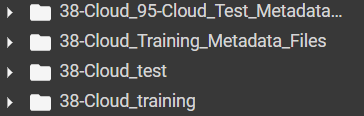

In [2]:
# Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Locate the json file
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [4]:
# Download and unzip the dataset
!kaggle datasets download -d sorour/38cloud-cloud-segmentation-in-satellite-images --unzip

100% 12.1G/12.2G [01:38<00:00, 144MB/s]
100% 12.2G/12.2G [01:38<00:00, 133MB/s]


### Define the dataset class 📪

In [53]:
# define random seed
random.seed(42)

In [45]:
# Dataset Class
class CloudDataset(Dataset):
    def __init__(self, r_dir, base_dir,train=True,pytorch=True):
        super().__init__()
        self.files = []
        for f in os.listdir(base_dir/r_dir):
            pattern = ".+(LC.*)"
            x = re.search(pattern, f)
            if train:
              self.files.append({
                  "red" : base_dir/"train_red"/f,
                  "green" : base_dir/"train_green"/f.replace("red","green"),
                  "blue" : base_dir/"train_blue"/f.replace("red","blue"),
                  "nir" : base_dir/"train_nir"/f.replace("red","nir"),
                  "gt" : base_dir/"train_gt"/f.replace("red","gt"),
              })
            else:
              self.files.append({
                  "red" : base_dir/"test_red"/f,
                  "green" : base_dir/"test_green"/f.replace("red","green"),
                  "blue" : base_dir/"test_blue"/f.replace("red","blue"),
                  "nir" : base_dir/"test_nir"/f.replace("red","nir"),
                  "gt" : base_dir/"test_gt"/f.replace("red","gt"),
              })
    def split_train_test(self, ratio = 0.7):
        self.X_train = []
        self.Y_train = []
        self.X_test = []
        self.Y_test = []
        self.shuffle()
        elements = len(self.files)
        middle = int(elements * ratio)
        train_files = self.files[:middle]
        test_files = self.files[middle:]         
        for f in train_files:
            try:
              pic_red = cv2.imread(str(f["red"]))
              pic_red.resize((384,384,1))
              pic_green = cv2.imread(str(f["green"]))
              pic_green.resize((384,384,1))
              pic_blue = cv2.imread(str(f["blue"]))
              pic_blue.resize((384,384,1))
              pic_gt = cv2.imread(str(f["gt"]))
              pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
              pic_nir = cv2.imread(str(f["nir"]))
              pic_nir.resize((384,384,1))
              pic = (np.dstack((pic_green,pic_blue,pic_red,pic_nir)) * 255.999) .astype(np.uint8)
              self.X_train.append(pic)
              self.Y_train.append(pic_gt)
            except:
              pass
        for f in test_files:
            try:
              pic_red = cv2.imread(str(f["red"]))
              pic_red.resize((384,384,1))
              pic_green = cv2.imread(str(f["green"]))
              pic_green.resize((384,384,1))
              pic_blue = cv2.imread(str(f["blue"]))
              pic_blue.resize((384,384,1))
              pic_gt = cv2.imread(str(f["gt"]))
              pic_gt = cv2.cvtColor(pic_gt, cv2.COLOR_BGR2GRAY)
              pic_nir = cv2.imread(str(f["nir"]))
              pic_nir.resize((384,384,1))
              pic = (np.dstack((pic_green,pic_blue,pic_red,pic_nir)) * 255.999) .astype(np.uint8)
              self.X_test.append(pic)
              self.Y_test.append(pic_gt)
            except:
              pass
        return (self.X_train,self.Y_train),(self.X_test,self.Y_test)
                                       
    def __len__(self):
        return len(self.files)

    def shuffle(self):
        return random.shuffle(self.files)

In [46]:
# Instantiate train and test data
base_train = Path('/content/38-Cloud_training')
base_test = Path('/content/38-Cloud_test')
data = CloudDataset(base_dir=base_train,r_dir='train_red')
test_data = CloudDataset(base_dir=base_test,r_dir='test_red',train=False)

In [47]:
# Merge test and train data
data.files += test_data.files

In [48]:
# Shuffle data
data.shuffle()

In [49]:
# Split data
(X_train,Y_train),(X_test,Y_test) = data.split_train_test(ratio = 0.7)

### Build the model 💻
For this task we will use U-Net model
![](https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png)
